In [1]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
log_paths = [
    "seed_1234_sample_rate_1_lr_0.1_n_epochs_300_hidden_dim_2_patience_100_log.pkl",
    "seed_1234_sample_rate_5_lr_0.1_n_epochs_300_hidden_dim_2_patience_100_log.pkl",
    "seed_1234_sample_rate_10_lr_0.1_n_epochs_300_hidden_dim_2_patience_100_log.pkl"
]

In [3]:
logs = []
for path in log_paths:
    with open(path,'rb') as file:
        logs.append(pickle.load(file))

max-epochs final loss 0.0094


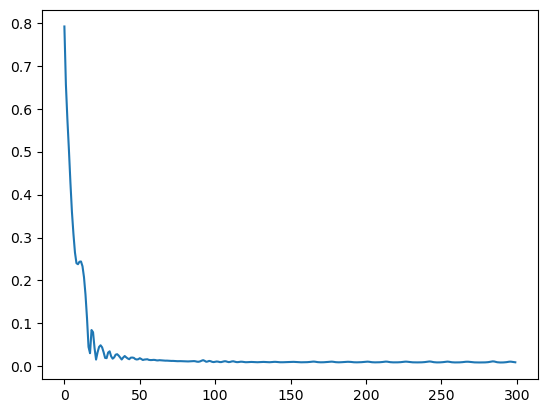

early-stoppage final loss 0.2544


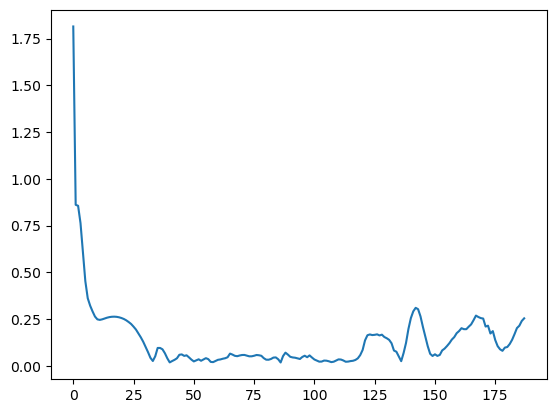

max-epochs final loss 0.0177


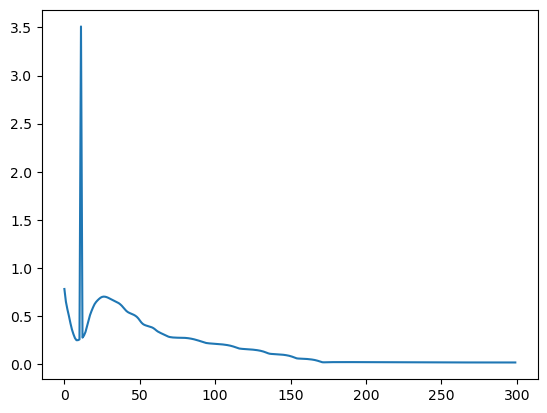

In [26]:
for log in logs:
    print(log["stopping_criteria"],  f"final loss {log['losses'][-1]:.4f}")
    plt.plot(log['losses'])
    plt.show()

In [16]:
tot_times = []
for log in logs:
    tot_times.append(np.sum(log["times"]))

In [20]:
np.array(tot_times)/60 /60

array([0.53739905, 0.06451827, 4.71582289])

In [28]:
logs[0].keys()

dict_keys(['losses', 'times', 'stopping_criteria', 'best_model_epoch', 'method_failures', 'patience_hist'])

In [29]:
fails = logs[-1]['method_failures']

In [32]:
np.count_nonzero(fails)

299